In [2]:
#Import Packages
import time, getpass
import numpy as np

import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
from lsst.daf.butler import Butler, CollectionType
from lsst.ip.isr import IsrTask, IsrTaskConfig
import lsst.ip.isr as isr
from astropy.io import fits
from matplotlib.patches import Rectangle
import lsst.pipe.tasks.characterizeImage as CIT
import matplotlib.cm as cm


import lsst.pipe.tasks.repair as repair
import galsim
from mpl_toolkits.axes_grid1 import make_axes_locatable

import lsst.geom as geom
from lsst.afw.image import Image
from lsst.afw.image import Exposure, ExposureF
import lsst.afw.display as afwDisplay
from lsst.rsp import get_tap_service

plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['image.cmap'] = 'gist_heat'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Make the code as functions 

In [3]:
#Set isr settings
isrConfig = IsrTaskConfig()
isrConfig.doLinearize=False
isrConfig.doOverscan=True
isrConfig.doAssembleCcd=True
isrConfig.doBias=False
isrConfig.doVariance=True
isrConfig.doLinearize=False
isrConfig.doCrosstalk=False
isrConfig.doBrighterFatter=False
isrConfig.doDark=False
isrConfig.doStrayLight=False
isrConfig.doFlat=False
isrConfig.doFringe=False
isrConfig.doApplyGains=False
isrConfig.doDefect=False
isrConfig.doNanMasking=True
isrConfig.doInterpolate=False
isrConfig.doSaturation=False
isrConfig.doSaturationInterpolation=False
isrConfig.doDefect = False
isrConfig.doDark = False
isrTask = IsrTask(config=isrConfig)

isrTask = isr.IsrTask(config=isrConfig)

In [4]:
#Set up the CharacterizeImage Task
IProcesser = CIT.CharacterizeImageTask()
IProcesser.config.doMeasurePsf = True
IProcesser.config.requireCrForPsf = True
IProcesser.config.repair.cosmicray.cond3_fac2 = 0.4
IProcesser.config.repair.cosmicray.nCrPixelMax = 100000
IProcesser.config.repair.cosmicray.minSigma = 5
IProcesser.config.repair.cosmicray.keepCRs = False

In [5]:
#Import ComCam darks
butler1 = Butler('/repo/embargo', collections=["LSSTComCam/raw/all", "LSSTComCam/calib"]) #I use ComCam data from the mountain for this project. 
dayObs = 20230728
expId = 2023072800156
exp = butler1.get('raw', detector=2, exposure=expId)
biasExp = butler1.get('bias', detector=2, exposure=expId)
flatExp = butler1.get('flat', detector=2, exposure=expId)
isrConfig.doBias=True
isrConfig.doFlat=True
isr_dark = isrTask.run(exp.clone(), bias = biasExp, flat=flatExp).exposure


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3553: UserWarning: Reading file:///tmp/tmpv05w2kxo.fits with data ID {instrument: 'LSSTComCam', detector: 2, physical_filter: 'r_03', band: 'r'}: filter label mismatch (file is None, data ID is FilterLabel(band="r", physical="r_03")).  This is probably a bug in the code that produced it.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#Import dp0.2 images from a custom repo
isrConfig.doBias=False
isrConfig.doFlat=False
butler2 = Butler('/home/n/nwoolsey/repo_example/repo', collections =['LSSTCam/raw/all', "LSSTCam/defaults"])
y = butler2.registry.queryDatasets(datasetType='raw')
expId = 2023101301390
Exposure = butler2.get(list(y)[10])
print(Exposure.getDetector().getId())
Expsoure = butler2.get('raw', detector = 32, exposure = expId)
#butler2.get('raw', detector=95, exposure=expId)
#xflatEXP = butler2.get('flat', detector = Exposure.getDetector().getId(), exposure=expId) 
#xbiasEXP = butler2.get('bias', detector = Exposure.getDetector().getId(), exposure=expId)
isr_data = isrTask.run(Exposure.clone()).exposure
isr_datawcs = isr_data.getWcs()


32


In [8]:
#Create a cutout of the dp0.2 exposure

ra, dec = isr_datawcs.pixelToSky(1750, 2650).getRa().asDegrees(), isr_datawcs.pixelToSky(1750, 2650).getDec().asDegrees()
radec = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(1001, 1001)
xy = geom.PointI(isr_datawcs.skyToPixel(radec))
bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
bbox
cutout = isr_data.getCutout(bbox)

#Isolate a cosmic ray from the dark image
cosmic = isr_dark.image.array[2260:2290,2810:2840]

In [9]:
#Run characterizeImage on the cutout to create a base image for comparisons
MidStep = IProcesser.run(cutout)


> WARNING: 1st context group-degree lowered (not enough samples)



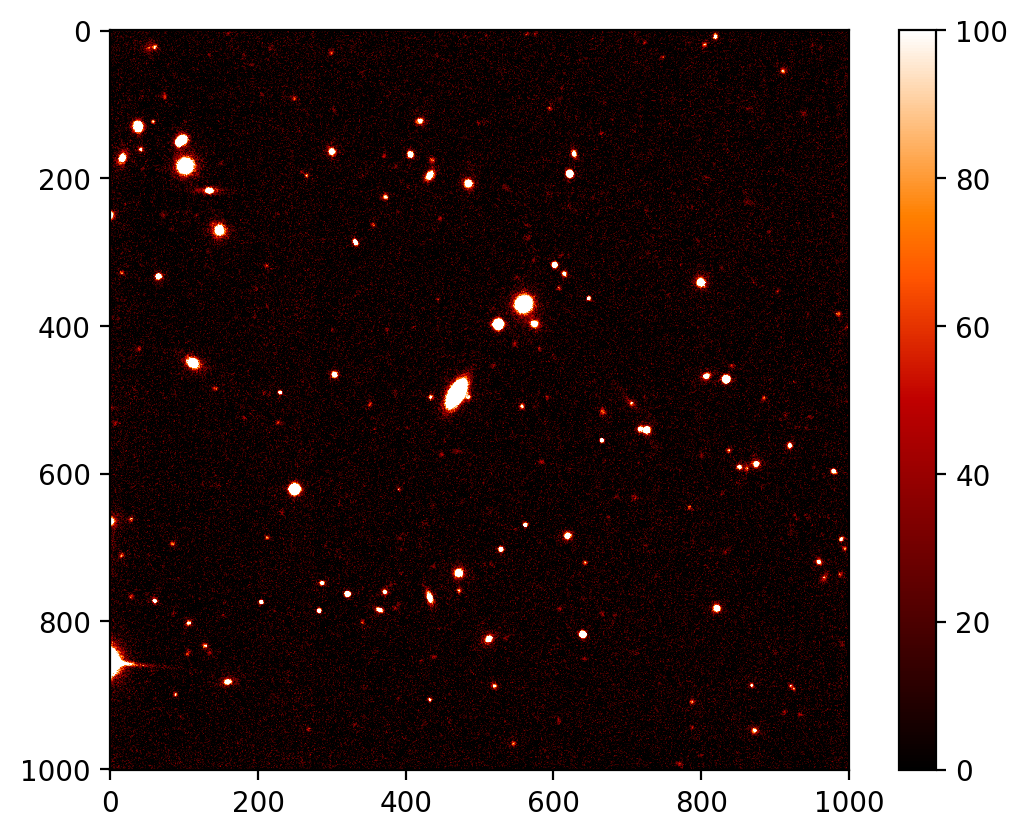

In [10]:
plt.imshow(MidStep.exposure.image.array, vmin=0, vmax=100)
plt.colorbar()

In [9]:
inCosmic = (cosmic > 99)
cosmicMask = []
for x in np.arange(0, 30, 1):
    for y in np.arange(0, 30, 1):
        if inCosmic[x,y]==True:
            cosmicMask.append([x,y])

#Make a mask that sets every pixel not in the cosmic to 0

In [11]:
type(MidStep)

lsst.pipe.base.struct.Struct

In [12]:
cosmic[cosmic<99] = 0

In [11]:
#This is the loop that clones the cutout, reruns the characterizeImage task, and extracts the shape.   
Shapesxy_noBias = []
Shapesyy_noBias = []
Shapesxx_noBias = []
spot_checker = []
overlaySaver = []
removedSaver = []
crFlagFinder = []
errorX = []
errorY = []
closestApproach=[]
for i in np.arange(250,600,2):
    test = MidStep.exposure.clone()
    test.image.array[0+i:30+i,470:500] = test.image.array[0+i:30+i,470:500]+cosmic
    #Save the overlay every 10 steps of the loop here (i%10 = 0 modular arithmatic)
    if i%10 == 0:
        #print("Check in between")
        overlaySaver.append(test.image.array[:,400:550].copy())
    tester = IProcesser.run(test)
    index = np.where((tester.sourceCat['base_SdssCentroid_x'] < 1725) & (tester.sourceCat['base_SdssCentroid_x'] > 1710)
      & (tester.sourceCat['base_SdssCentroid_y'] < 2650) & (tester.sourceCat['base_SdssCentroid_y'] > 2635))[0][0]
    Shapesxy_noBias.append(tester.sourceCat['ext_shapeHSM_HsmSourceMoments_xy'][index])
    Shapesyy_noBias.append(tester.sourceCat['ext_shapeHSM_HsmSourceMoments_yy'][index])
    Shapesxx_noBias.append(tester.sourceCat['ext_shapeHSM_HsmSourceMoments_xx'][index])
    spot_checker.append(tester.sourceCat['base_SdssCentroid_x'][index])
    crFlagFinder.append(tester.sourceCat["base_PixelFlags_flag_cr"][index])
    errorX.append(tester.sourceCat["base_SdssCentroid_xErr"][index])
    errorY.append(tester.sourceCat["base_SdssCentroid_yErr"][index])
    #Also save image after cosmic removal 
    
    centx = tester.sourceCat['base_SdssCentroid_x'][index]
    centy = tester.sourceCat['base_SdssCentroid_y'][index]


    RdistanceArray = []
    CdistanceArray = []
    RdistanceArrayRev = []
    CdistanceArrayRev = []
    #Rowperimeter
    for z in np.arange(0, len(cosmicMask), 1):
        x, y = 1250+i+cosmicMask[z][0], 2150+i+cosmicMask[z][1]
        for l in np.arange(0, tester.sourceCat[index].getFootprint().getSpans().asArray().shape[0], 1):
            for m in np.arange(0, tester.sourceCat[index].getFootprint().getSpans().asArray().shape[1], 1):
                if tester.sourceCat[index].getFootprint().getSpans().asArray()[l,m]==True:
                    xpos, ypos = 1689+l, 2602+m
                    break
            if np.sqrt((xpos-centx)**2 + (ypos-centy)**2) > np.sqrt((centx-x)**2 + (centy-y)**2):
                RdistanceArray.append(-1*np.sqrt((xpos-x)**2 + (ypos-y)**2))
            else:
                RdistanceArray.append(np.sqrt((xpos-x)**2 + (ypos-y)**2))
            
        #Colperimeter
        for m in np.arange(0, tester.sourceCat[index].getFootprint().getSpans().asArray().shape[1], 1):
            for l in np.arange(0, tester.sourceCat[index].getFootprint().getSpans().asArray().shape[0], 1):
                if tester.sourceCat[index].getFootprint().getSpans().asArray()[l,m]==True:
                    xpos, ypos = 1689+l, 2602+m
                    break
            if np.sqrt((xpos-centx)**2 + (ypos-centy)**2) > np.sqrt((centx-x)**2 + (centy-y)**2):
                CdistanceArray.append(-1*np.sqrt((xpos-x)**2 + (ypos-y)**2))
            else:
                CdistanceArray.append(np.sqrt((xpos-x)**2 + (ypos-y)**2))    


        for l in range(MidStep.sourceCat[index].getFootprint().getSpans().asArray().shape[0]-1, 0, -1):
            for m in np.arange(MidStep.sourceCat[index].getFootprint().getSpans().asArray().shape[1]-1, 0, -1):
                if MidStep.sourceCat[index].getFootprint().getSpans().asArray()[l,m]==True:
                    xpos, ypos = 1689+l, 2602+m
                    break
            if np.sqrt((xpos-centx)**2 + (ypos-centy)**2) > np.sqrt((centx-x)**2 + (centy-y)**2):
                RdistanceArrayRev.append(-1*np.sqrt((xpos-x)**2 + (ypos-y)**2))
            else:
                RdistanceArrayRev.append(np.sqrt((xpos-x)**2 + (ypos-y)**2))
    
    
        for m in np.arange(MidStep.sourceCat[index].getFootprint().getSpans().asArray().shape[1]-1, 0, -1):
            for l in np.arange(MidStep.sourceCat[index].getFootprint().getSpans().asArray().shape[0]-1, 0, -1):
                if MidStep.sourceCat[index].getFootprint().getSpans().asArray()[l,m]==True:
                    xpos, ypos = 1689+l, 2602+m
                    break
            if np.sqrt((xpos-centx)**2 + (ypos-centy)**2) > np.sqrt((centx-x)**2 + (centy-y)**2):
                CdistanceArrayRev.append(-1*np.sqrt((xpos-x)**2 + (ypos-y)**2))
            else:
                CdistanceArrayRev.append(np.sqrt((xpos-x)**2 + (ypos-y)**2))

    RMinDistance = min(RdistanceArray, key=abs)
    CMinDistance = min(CdistanceArray, key=abs)
    RRevMinDistance = min(RdistanceArrayRev, key=abs)
    CRevMinDistance = min(CdistanceArrayRev, key=abs)
    

    closestApproach.append(min([RMinDistance, CMinDistance, RRevMinDistance, CRevMinDistance], key=abs))

    if i%10 == 0:
        #print("Check in between")
        removedSaver.append(tester.exposure.image.array[:,400:550].copy())
    del(tester)

In [12]:
min([RMinDistance, CMinDistance, RRevMinDistance, CRevMinDistance], key=abs)

165.46298679765212

In [13]:
lst = [-1, 10, -100, 0]
min(lst, key=abs)

0

In [14]:
closestApproach

[271.0885464197999,
 268.26293072282647,
 265.4373749116729,
 262.6118809193522,
 259.7864507629295,
 256.96108654813867,
 254.13579047430528,
 251.3105648396024,
 248.4854120466632,
 245.66033460858105,
 242.83533515532702,
 240.01041644062033,
 237.1855813492886,
 234.3608329051593,
 231.53617427952807,
 228.7116088002531,
 225.88713996153035,
 223.06277143441037,
 220.238507078122,
 217.4143509522773,
 214.59030733003763,
 211.7663807123312,
 208.94257584322062,
 206.11889772653063,
 203.2953516438583,
 200.47194317410106,
 197.6486782146544,
 194.82556300444764,
 192.00260414900626,
 189.17980864775183,
 186.3571839237758,
 183.53473785635242,
 180.71247881648904,
 177.89041570584965,
 175.06855799943062,
 172.246915792417,
 169.42549985170473,
 166.6043216726385,
 163.783393541592,
 160.96272860510285,
 158.14234094637652,
 155.32224567009067,
 152.50245899656832,
 149.68299836654796,
 146.8638825579659,
 144.04513181638595,
 141.2267680009707,
 138.4088147481944,
 135.59129765585

In [15]:
-1*np.sqrt((xpos-x)**2 + (ypos-y)**2)

-201.63581031156147

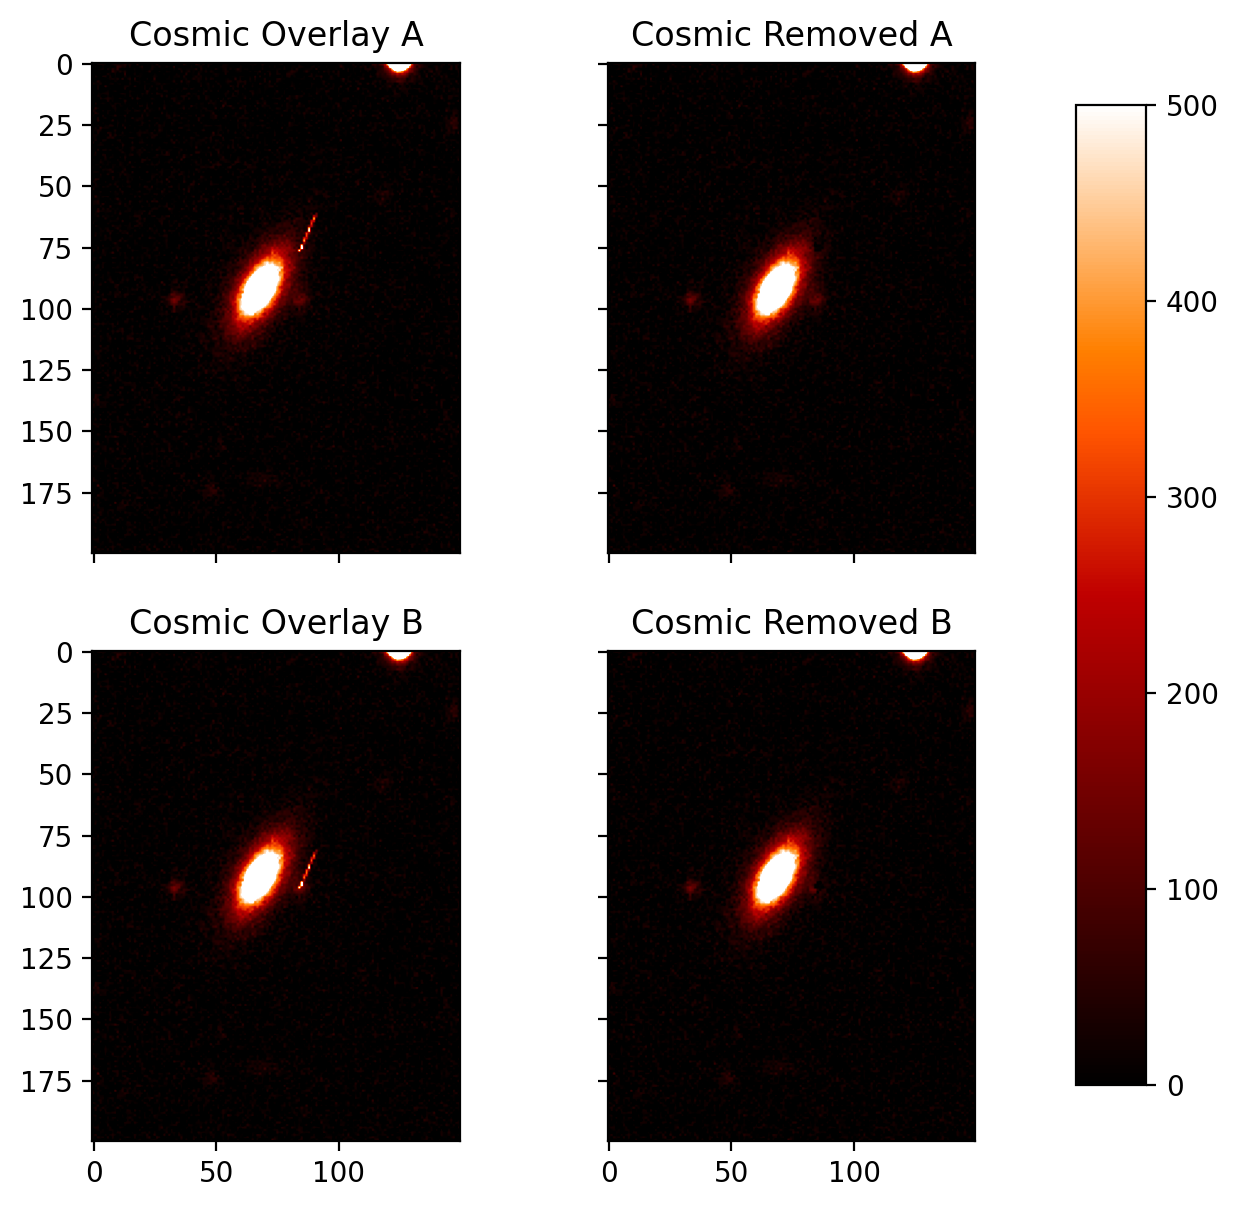

In [16]:
fig, ax = plt.subplots(figsize=(7,7), nrows=2, ncols=2, sharex=True, sharey = True)
ax[0,0].imshow(overlaySaver[20][400:600,:], vmin = 0, vmax = 500)
ax[0,0].title.set_text("Cosmic Overlay A")
#ax[0,0].title
#plt.savefig("overlayDipA.png")

ax[0,1].imshow(removedSaver[20][400:600,:], vmin = 0, vmax = 500)
ax[0,1].title.set_text("Cosmic Removed A")
#plt.savefig("removedDipA.png")

ax[1,0].imshow(overlaySaver[22][400:600,:], vmin = 0, vmax = 500)
ax[1,0].title.set_text("Cosmic Overlay B")
#plt.savefig("OverlaySpikeB.png")


ax[1,1].imshow(removedSaver[22][400:600,:], vmin = 0, vmax = 500)
ax[1,1].title.set_text("Cosmic Removed B")
#plt.savefig("removedSpikeB.png")


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax[1,0].imshow(overlaySaver[22][400:600,:], vmin = 0, vmax = 500), cax=cbar_ax)


#plt.savefig('SubplotImage2.png')


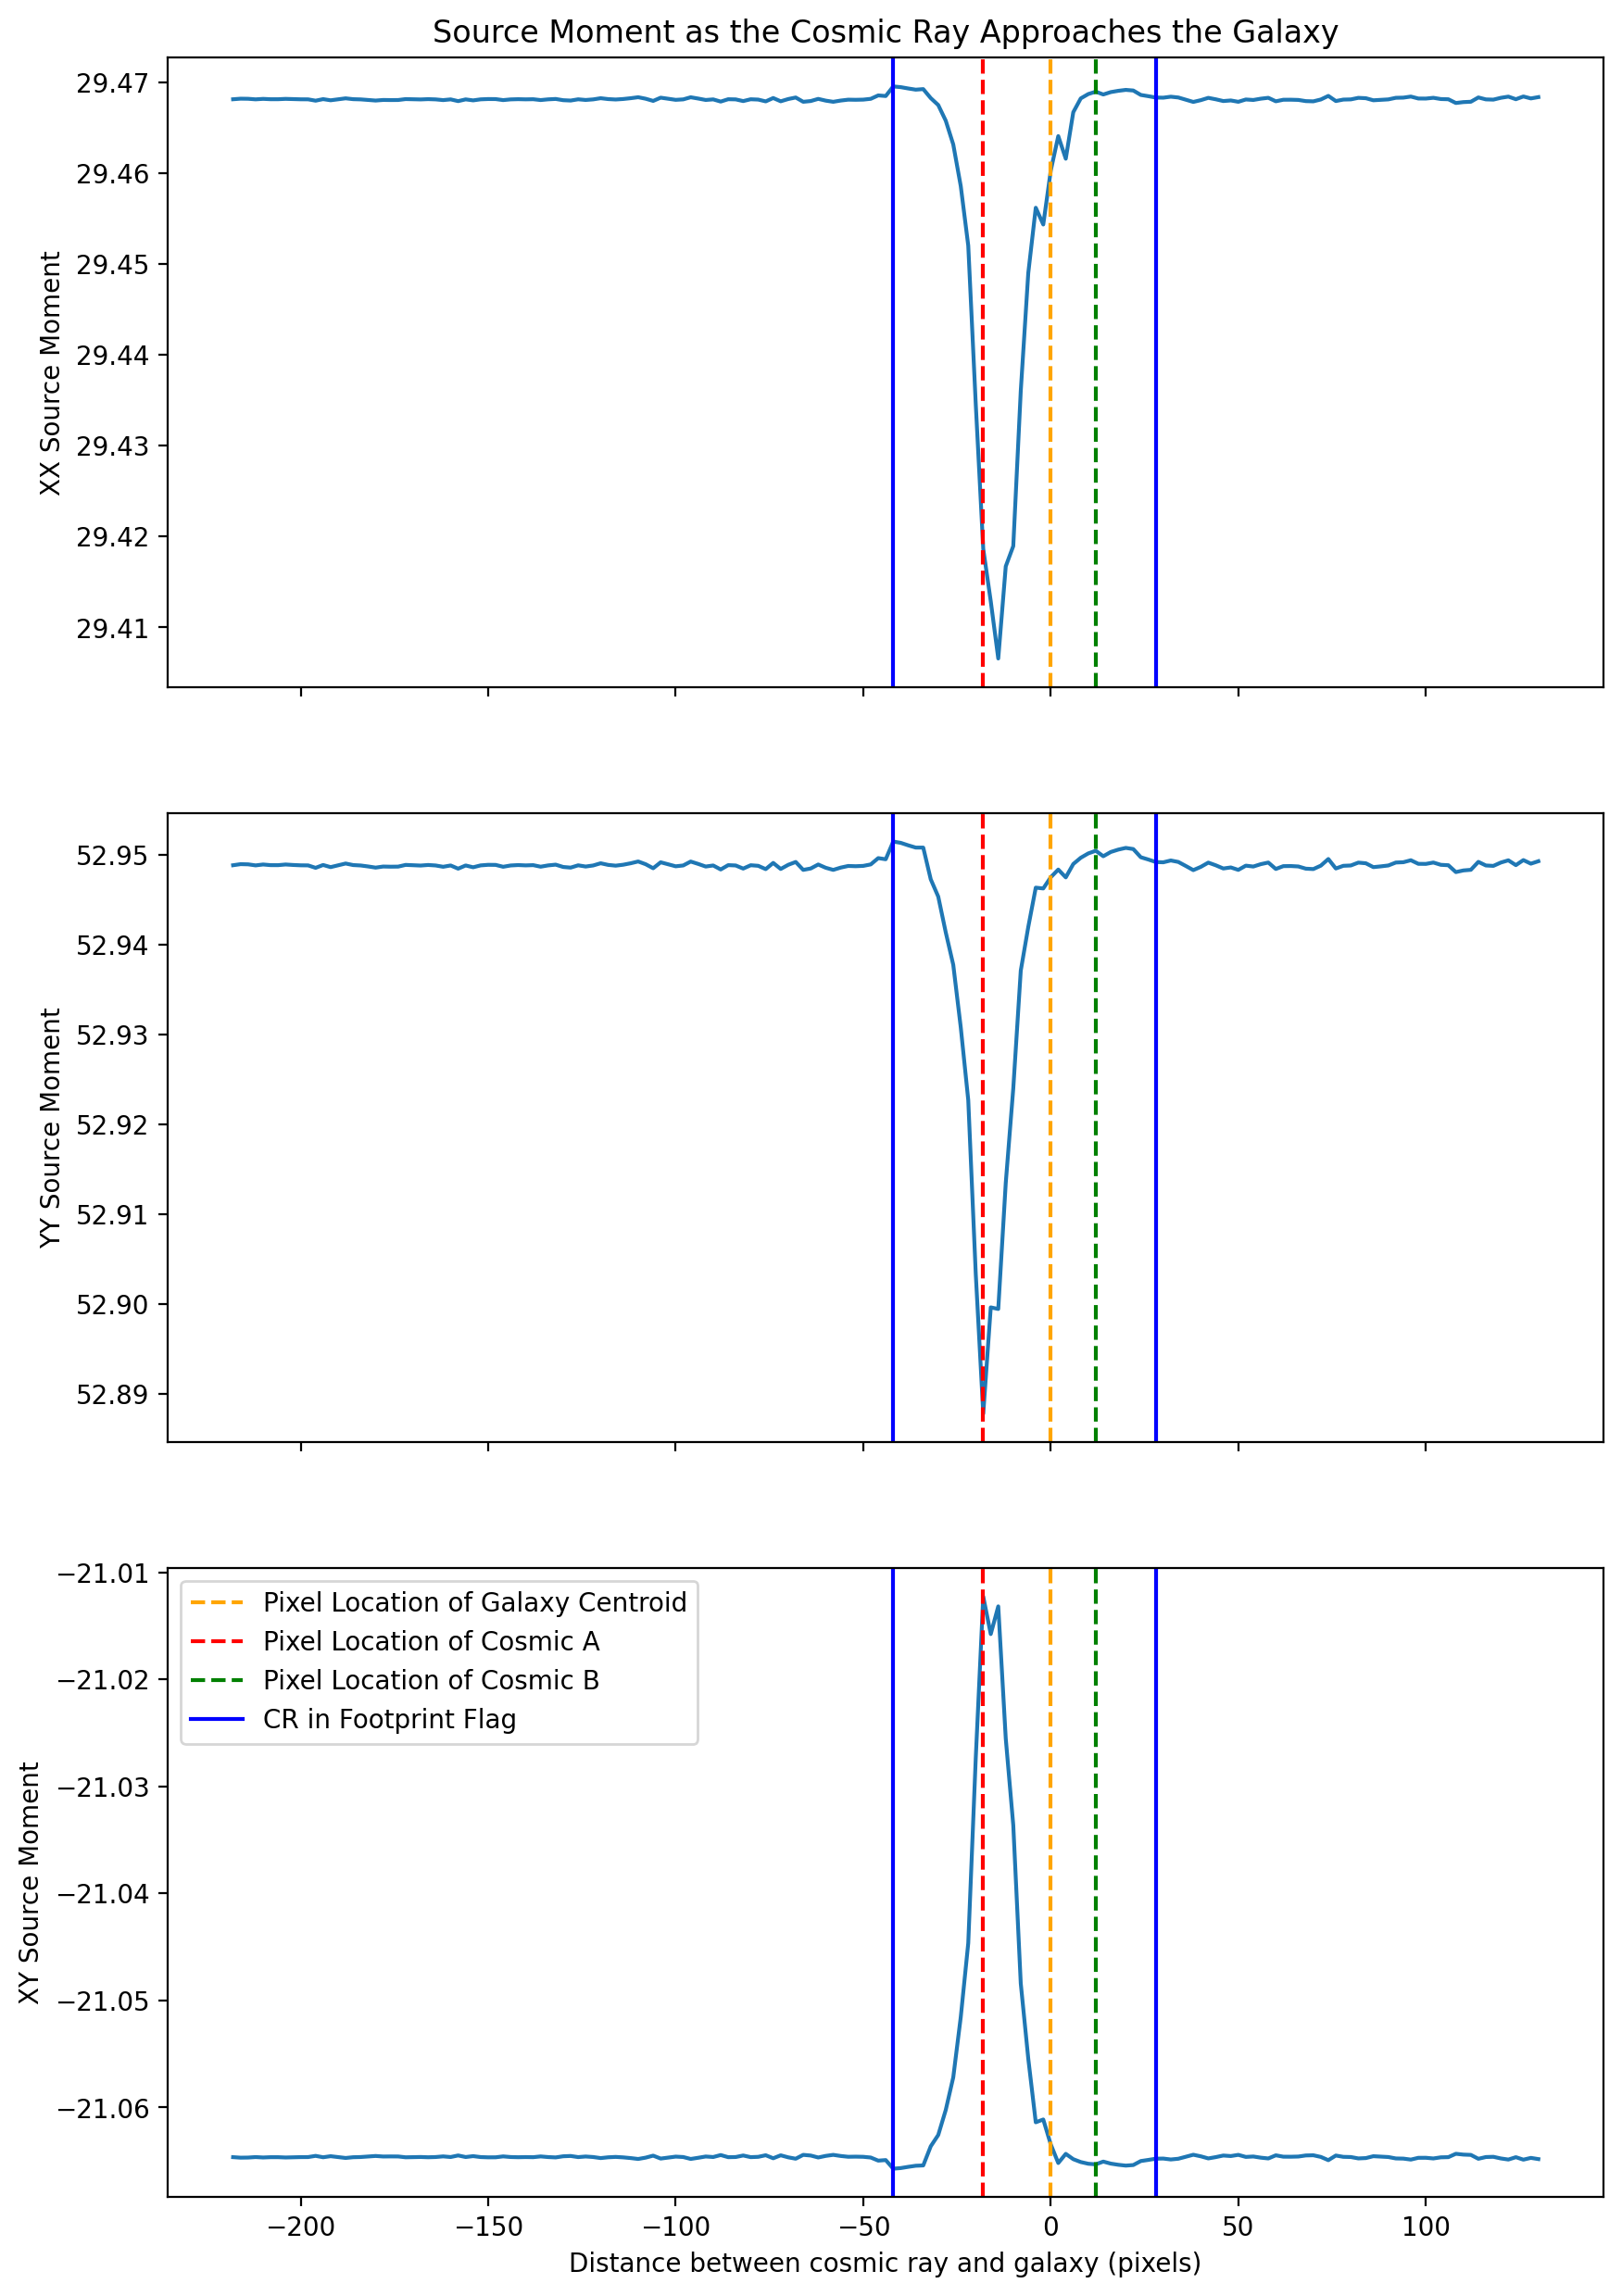

In [17]:
x = np.arange(250,600, 2)
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10,15), nrows=3, ncols=1,sharex=True)
ax1.plot(x-468,Shapesxx_noBias)
ax1.set_ylabel("XX Source Moment")
#ax1.set_xlabel("Distance between cosmic ray and galaxy (pixels)")
ax1.axvline(x = 0, color = 'orange', linestyle = 'dashed', label = "Pixel location of galaxy center")
ax1.axvline(x = 450-468, color = 'red', linestyle = 'dashed', label = "Pixel Location of Cosmic A")
ax1.axvline(x = 480-468, color = 'green', linestyle = 'dashed', label = "Pixel Location of Cosmic B")
ax1.axvline(x = 426-468, color = 'blue', linestyle = 'solid', label = "Flag")
ax1.axvline(x = 496-468, color = 'blue', linestyle = 'solid')
ax1.title.set_text("Source Moment as the Cosmic Ray Approaches the Galaxy")


ax2.plot(x-468,Shapesyy_noBias)
ax2.set_ylabel("YY Source Moment")
#ax2.set_xlabel("Distance between cosmic ray and galaxy (pixels)")
ax2.axvline(x = 468-468, color = 'orange', linestyle = 'dashed', label = "Pixel location of galaxy center")
ax2.axvline(x = 450-468, color = 'red', linestyle = 'dashed', label = "Pixel Location of Cosmic A")
ax2.axvline(x = 480-468, color = 'green', linestyle = 'dashed', label = "Pixel Location of Cosmic B")
ax2.axvline(x = 426-468, color = 'blue', linestyle = 'solid', label = "Flag")
ax2.axvline(x = 496-468, color = 'blue', linestyle = 'solid')
#ax2.title.set_text("YY moment as the cosmic approaches the galaxy")

ax3.plot(x-468,Shapesxy_noBias)
ax3.set_ylabel("XY Source Moment")
ax3.set_xlabel("Distance between cosmic ray and galaxy (pixels)")
ax3.axvline(x = 468-468, color = 'orange', linestyle = 'dashed', label = "Pixel Location of Galaxy Centroid")
ax3.axvline(x = 450-468, color = 'red', linestyle = 'dashed', label = "Pixel Location of Cosmic A")
ax3.axvline(x = 480-468, color = 'green', linestyle = 'dashed', label = "Pixel Location of Cosmic B")
ax3.axvline(x = 426-468, color = 'blue', linestyle = 'solid', label = "CR in Footprint Flag")
ax3.axvline(x = 496-468, color = 'blue', linestyle = 'solid')
#ax3.title.set_text("XY moment as the cosmic approaches the galaxy")




plt.legend()
plt.savefig("MomentHist2.png")

In [18]:
closestNegative = np.concatenate((-1*np.asarray(closestApproach[0:np.where(x-468==0)[0][0]]), np.asarray(closestApproach[np.where(x-468==0)[0][0]:175])))


In [19]:
MidStep.sourceCat[index].getFootprint().getBBox()
MidStep.sourceCat[index].getFootprint().getBBox().getCorners()

[Point2I(1689, 2602),
 Point2I(1745, 2602),
 Point2I(1745, 2679),
 Point2I(1689, 2679)]

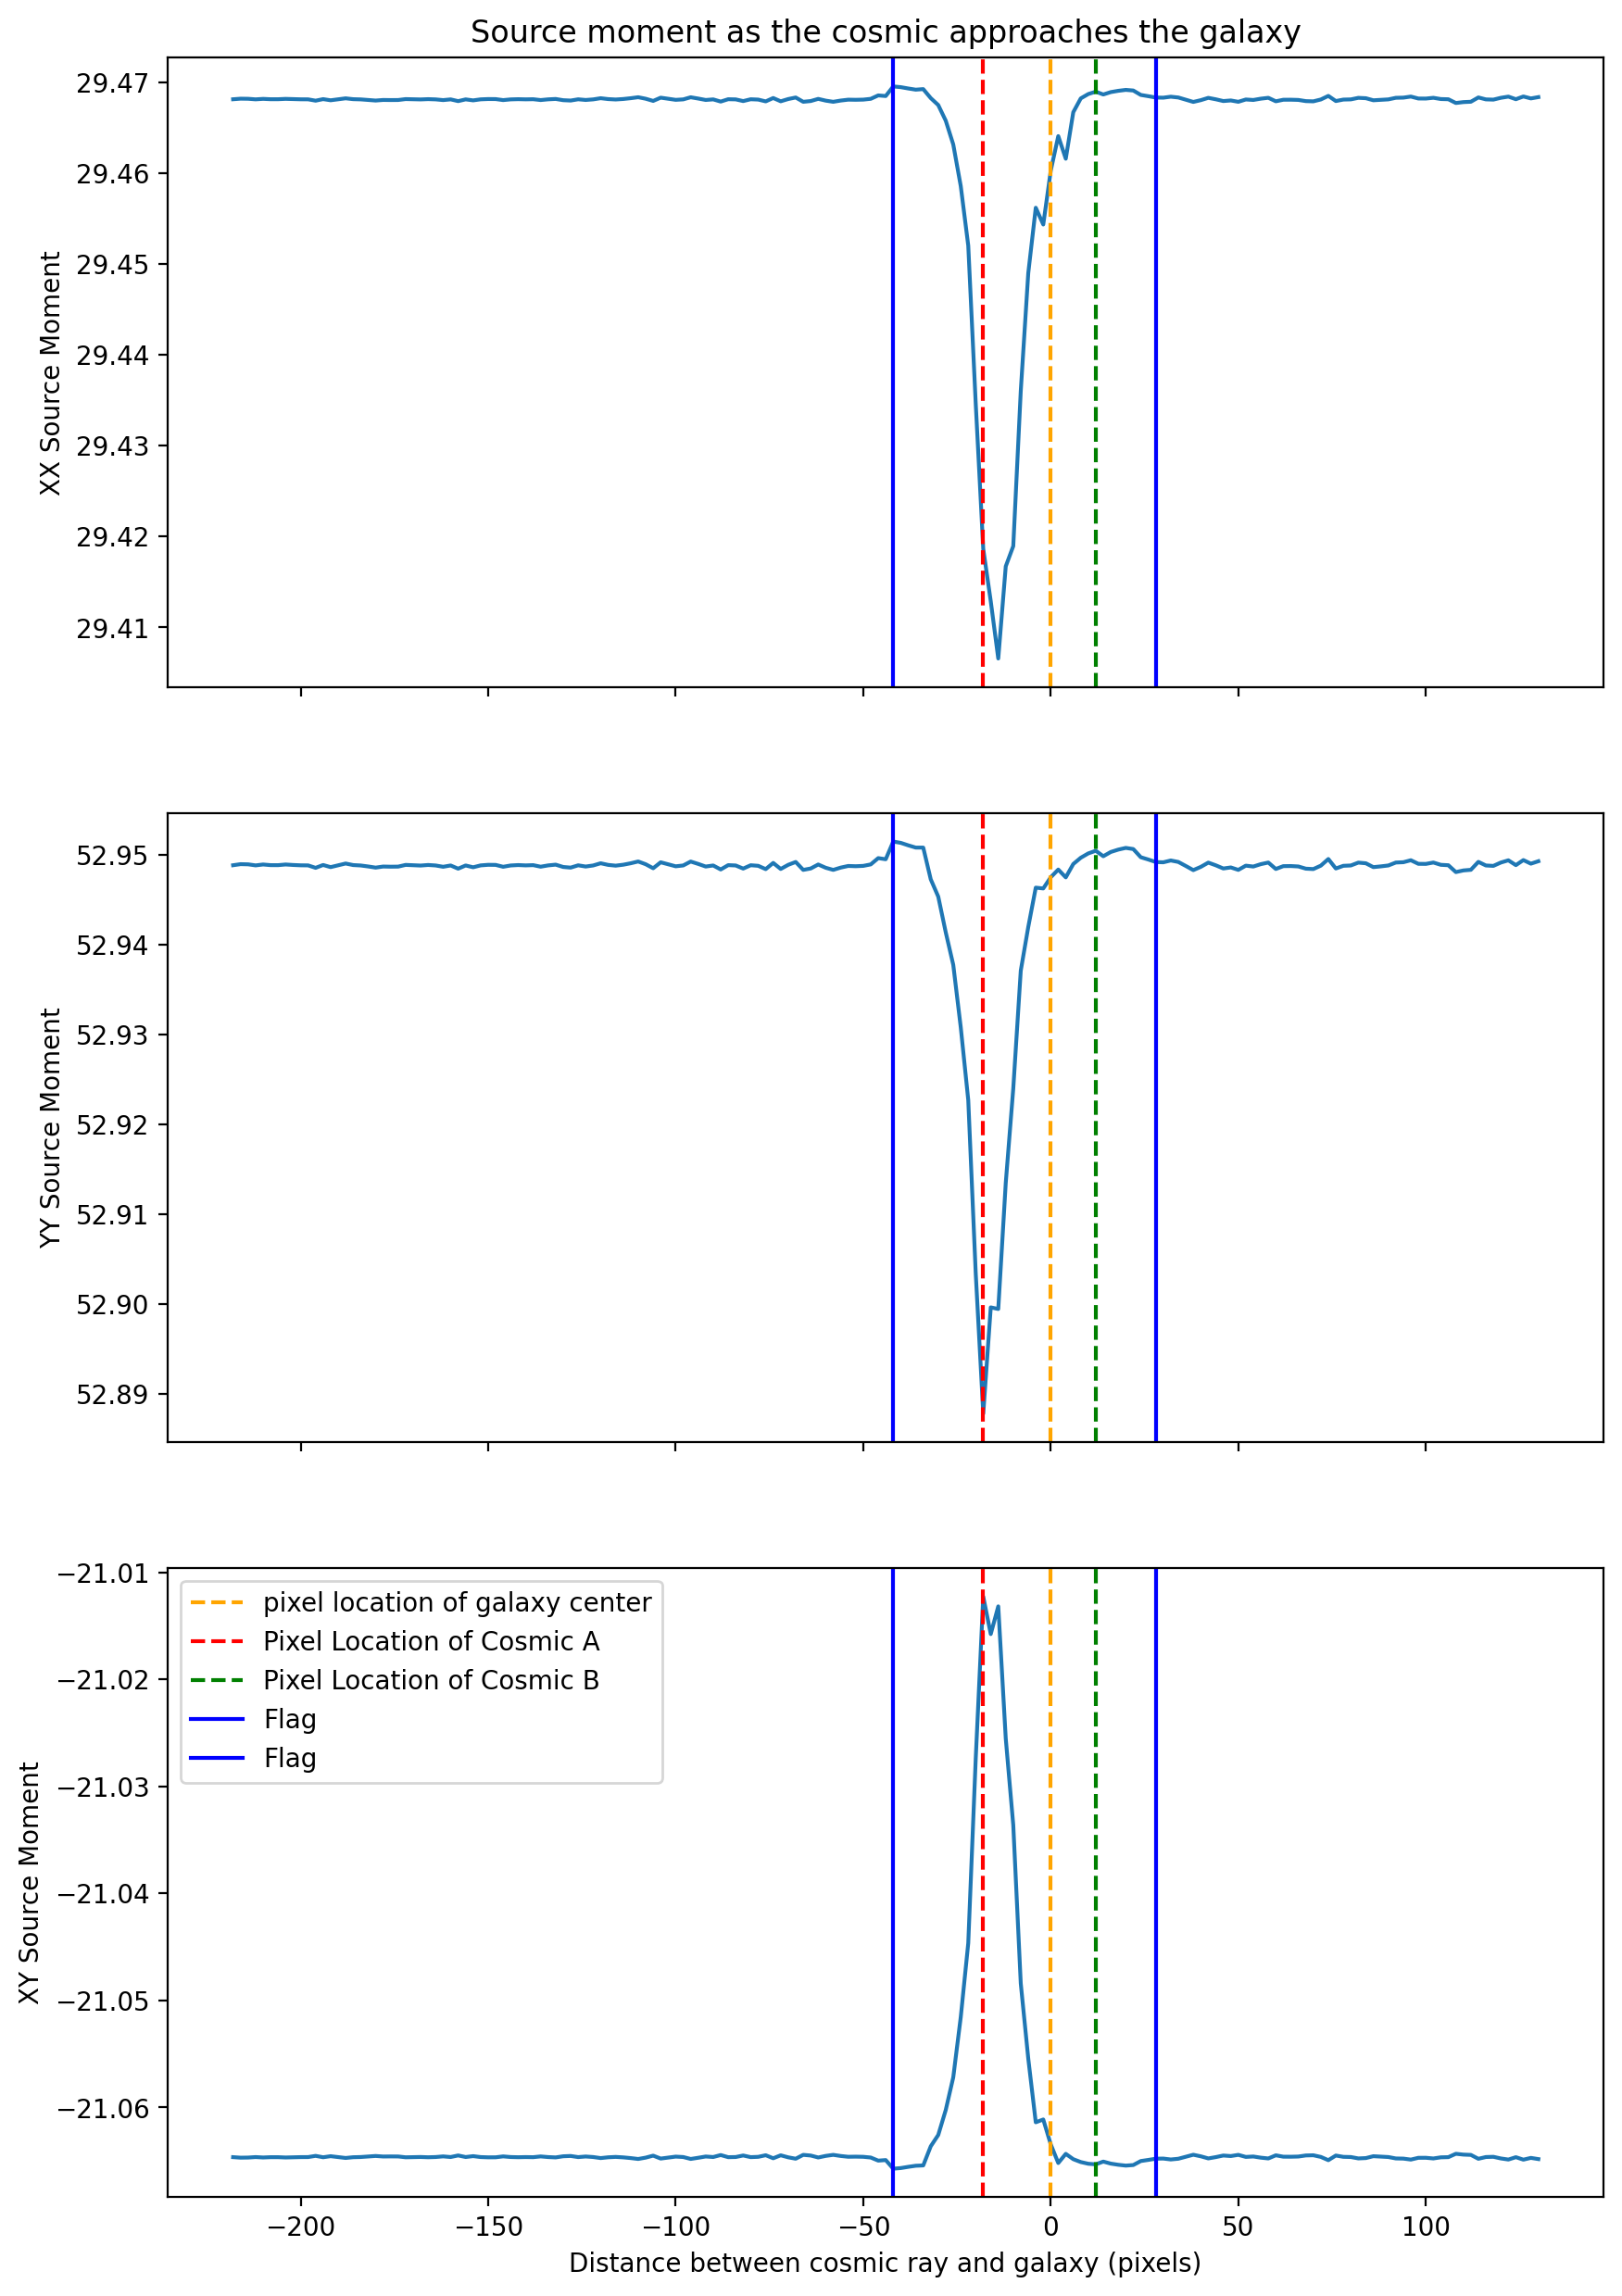

In [20]:
x = np.arange(250,600, 2)
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10,15), nrows=3, ncols=1,sharex=True)
ax1.plot(x-468,Shapesxx_noBias)
ax1.set_ylabel("XX Source Moment")
#ax1.set_xlabel("Distance between cosmic ray and galaxy (pixels)")
ax1.axvline(x = 0, color = 'orange', linestyle = 'dashed', label = "pixel location of galaxy center")
ax1.axvline(x = 450-468, color = 'red', linestyle = 'dashed', label = "Pixel Location of Cosmic A")
ax1.axvline(x = 480-468, color = 'green', linestyle = 'dashed', label = "Pixel Location of Cosmic B")
ax1.axvline(x = 426-468, color = 'blue', linestyle = 'solid', label = "Flag")
ax1.axvline(x = 496-468, color = 'blue', linestyle = 'solid', label = "Flag")
ax1.title.set_text("Source moment as the cosmic approaches the galaxy")


ax2.plot(x-468,Shapesyy_noBias)
ax2.set_ylabel("YY Source Moment")
#ax2.set_xlabel("Distance between cosmic ray and galaxy (pixels)")
ax2.axvline(x = 468-468, color = 'orange', linestyle = 'dashed', label = "pixel location of galaxy center")
ax2.axvline(x = 450-468, color = 'red', linestyle = 'dashed', label = "Pixel Location of Cosmic A")
ax2.axvline(x = 480-468, color = 'green', linestyle = 'dashed', label = "Pixel Location of Cosmic B")
ax2.axvline(x = 426-468, color = 'blue', linestyle = 'solid', label = "Flag")
ax2.axvline(x = 496-468, color = 'blue', linestyle = 'solid', label = "Flag")
#ax2.title.set_text("YY moment as the cosmic approaches the galaxy")

ax3.plot(x-468,Shapesxy_noBias)
ax3.set_ylabel("XY Source Moment")
ax3.set_xlabel("Distance between cosmic ray and galaxy (pixels)")
ax3.axvline(x = 468-468, color = 'orange', linestyle = 'dashed', label = "pixel location of galaxy center")
ax3.axvline(x = 450-468, color = 'red', linestyle = 'dashed', label = "Pixel Location of Cosmic A")
ax3.axvline(x = 480-468, color = 'green', linestyle = 'dashed', label = "Pixel Location of Cosmic B")
ax3.axvline(x = 426-468, color = 'blue', linestyle = 'solid', label = "Flag")
ax3.axvline(x = 496-468, color = 'blue', linestyle = 'solid', label = "Flag")
#ax3.title.set_text("XY moment as the cosmic approaches the galaxy")




plt.legend()
plt.savefig("MomentHistNoBias.png")

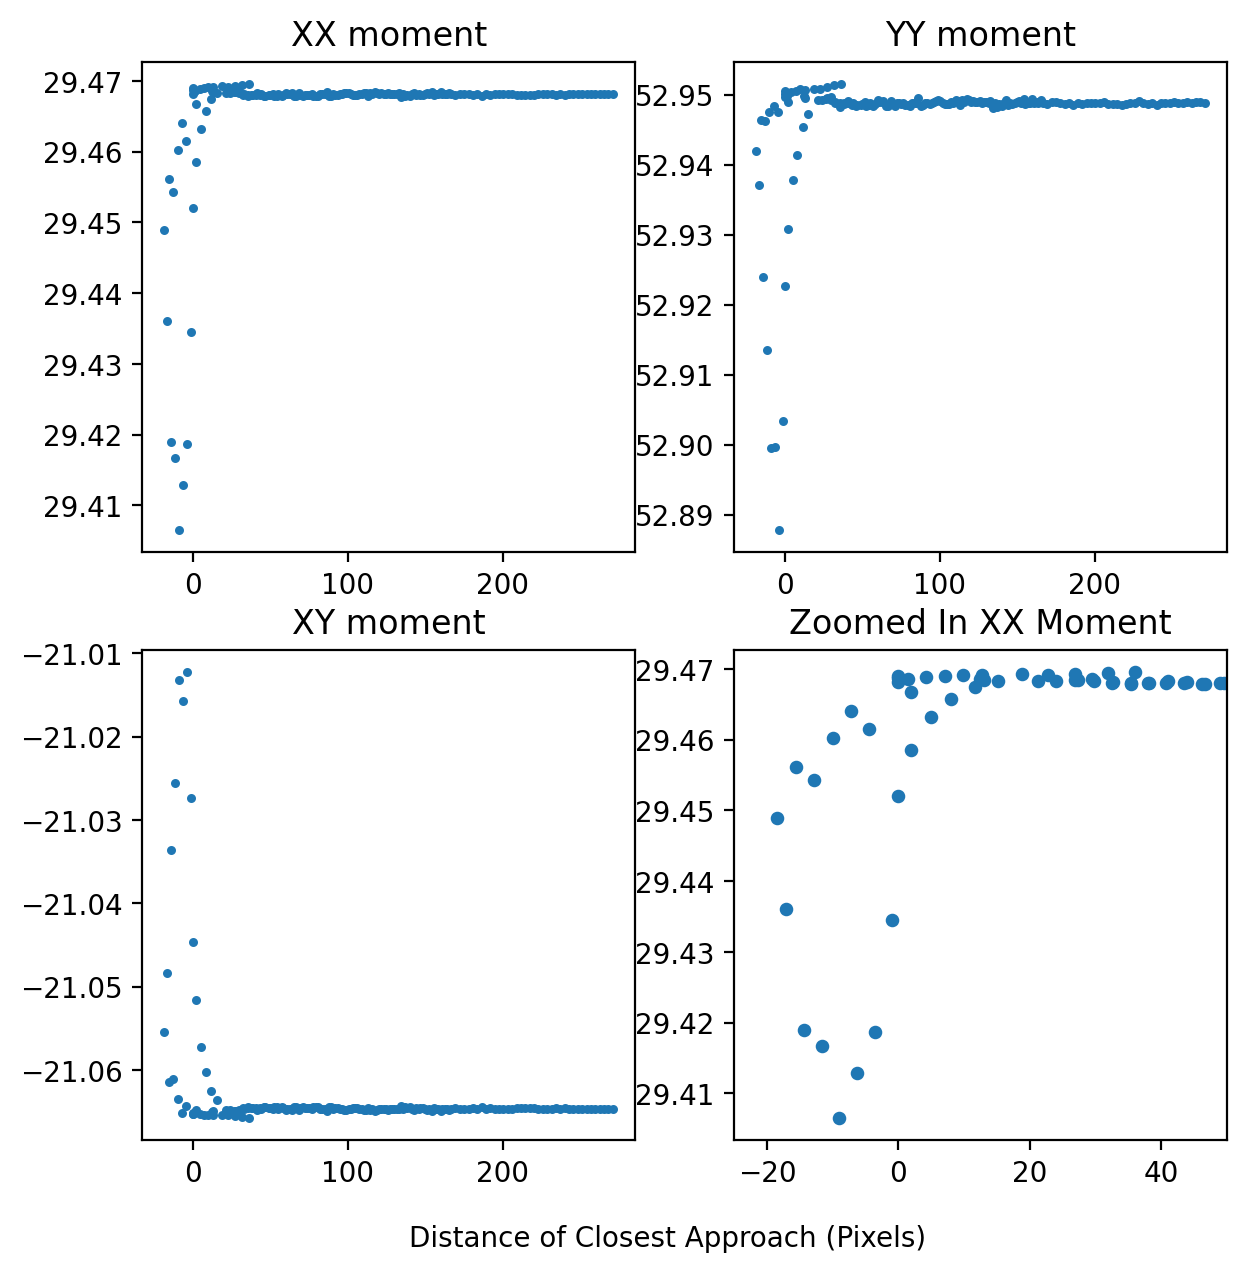

In [28]:
fig, ax = plt.subplots(figsize=(7,7), nrows=2, ncols=2)
ax[0,0].scatter(closestApproach, Shapesxx_noBias, s=5)
ax[0,0].title.set_text('XX moment')


ax[0,1].scatter(closestApproach, Shapesyy_noBias, s=5)
ax[0,1].title.set_text('YY moment')

ax[1,0].scatter(closestApproach, Shapesxy_noBias, s=5)
ax[1,0].title.set_text('XY moment')

ax[1,1].scatter(closestApproach, Shapesxx_noBias, s=15)
ax[1,1].set_xlim([-25,50])
ax[1,1].title.set_text('Zoomed In XX Moment')


#ax.set_xlabel('distance of closest approach')
fig.text(0.5, 0.04, 'Distance of Closest Approach (Pixels)', ha='center', va='center')

plt.savefig('ClosestApproach1.png')

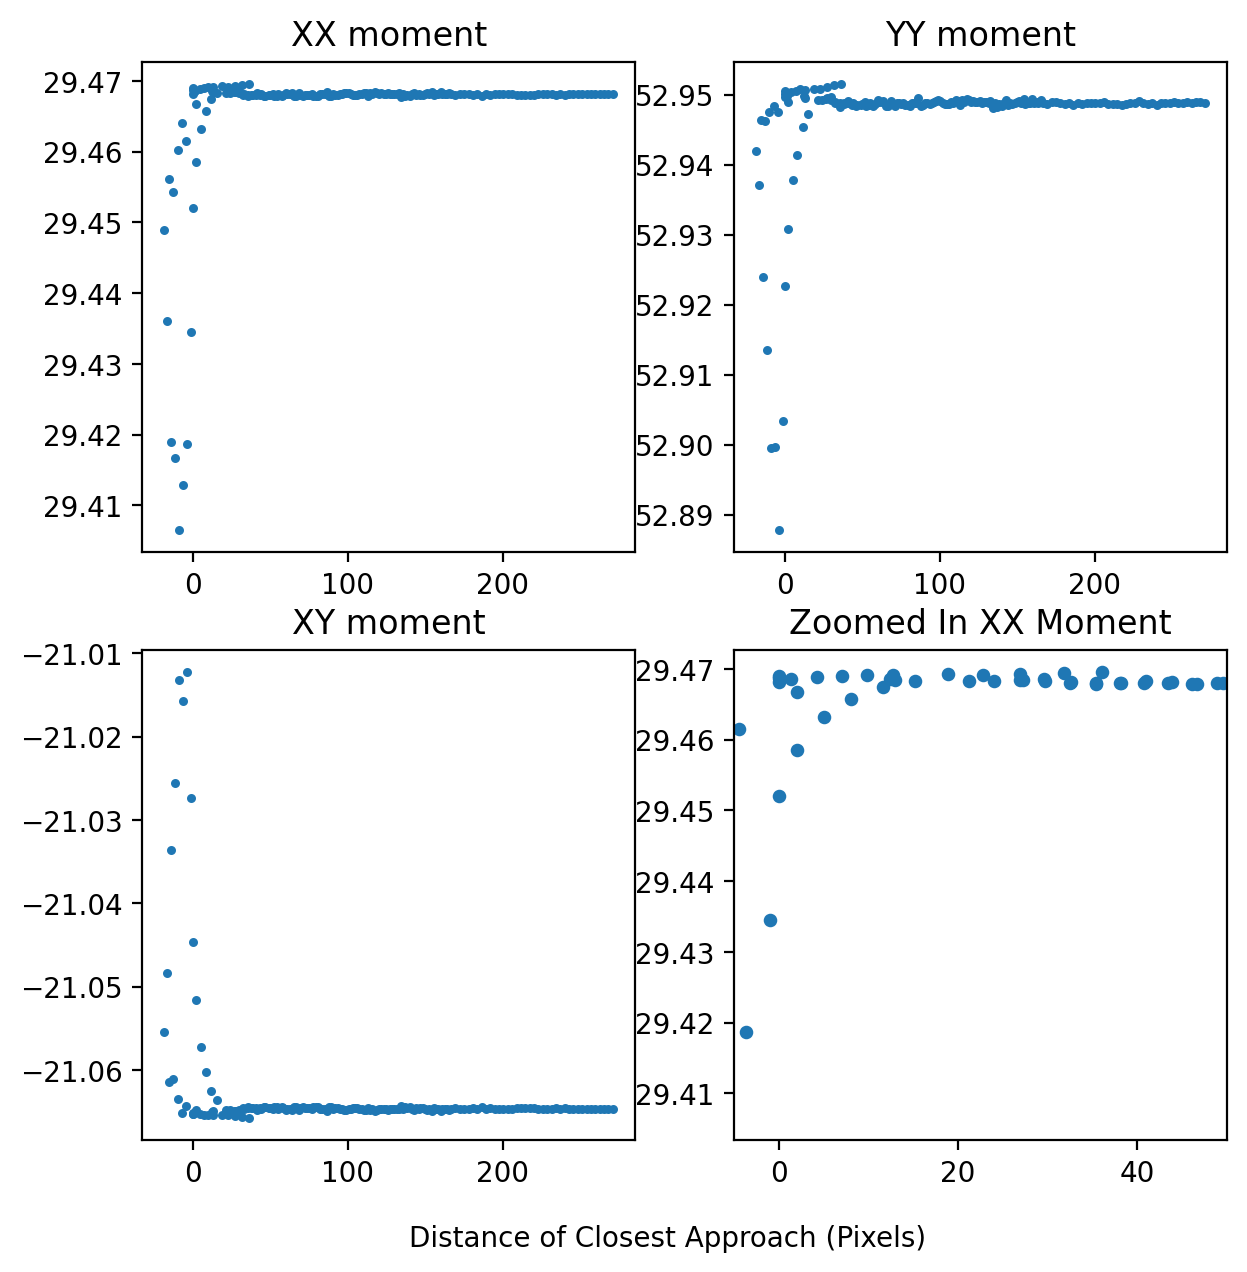

In [22]:
fig, ax = plt.subplots(figsize=(7,7), nrows=2, ncols=2)
ax[0,0].scatter(closestApproach, Shapesxx_noBias, s=5)
ax[0,0].title.set_text('XX moment')


ax[0,1].scatter(closestApproach, Shapesyy_noBias, s=5)
ax[0,1].title.set_text('YY moment')

ax[1,0].scatter(closestApproach, Shapesxy_noBias, s=5)
ax[1,0].title.set_text('XY moment')

ax[1,1].scatter(closestApproach, Shapesxx_noBias, s=15)
ax[1,1].set_xlim([-5,50])
ax[1,1].title.set_text('Zoomed In XX Moment')


#ax.set_xlabel('distance of closest approach')
fig.text(0.5, 0.04, 'Distance of Closest Approach (Pixels)', ha='center', va='center')

plt.savefig('ClosestApproachNoBias3.png')

In [23]:
closestApproach = np.asarray(closestApproach)
len(closestApproach[closestApproach<20])

31

In [24]:
#MidStep.sourceCat[index].getFootprint().getSpans().asArray()[1,:]

In [25]:
MidStep.sourceCat.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_psf_candidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psf_used", doc="Flag set if the source was actually used for PSF determination, as determined by the 'psfex' PSF determiner."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psf_reserved", doc="set if source was reserved from PSF determination"), Key['Flag'](offset=32, bit=2)),
    (Field['D'](name="base_SdssCentroid_x", doc="centroid from Sdss Centroid algorithm", units="pixel"

In [26]:
d = np.asarray(Shapesxx_noBias)-29
d = np.asarray(d[closestApproach <= 20])

print(closestApproach[closestApproach <= 20][7:25], d[7:25])

[ -1.          -3.60555128  -6.32455532  -8.94427191 -11.66190379
 -14.31782106 -17.         -18.43908891 -15.62049935 -12.80624847
 -10.          -7.21110255  -4.47213595   2.           0.
   0.           0.           1.41421356] [0.43455556 0.41862526 0.41286555 0.40656784 0.41671325 0.41893845
 0.43601295 0.44898597 0.45618005 0.45433149 0.46027212 0.4640628
 0.46157075 0.46669111 0.46821419 0.46869147 0.46895293 0.46864221]


IndexError: index 31 is out of bounds for axis 0 with size 31

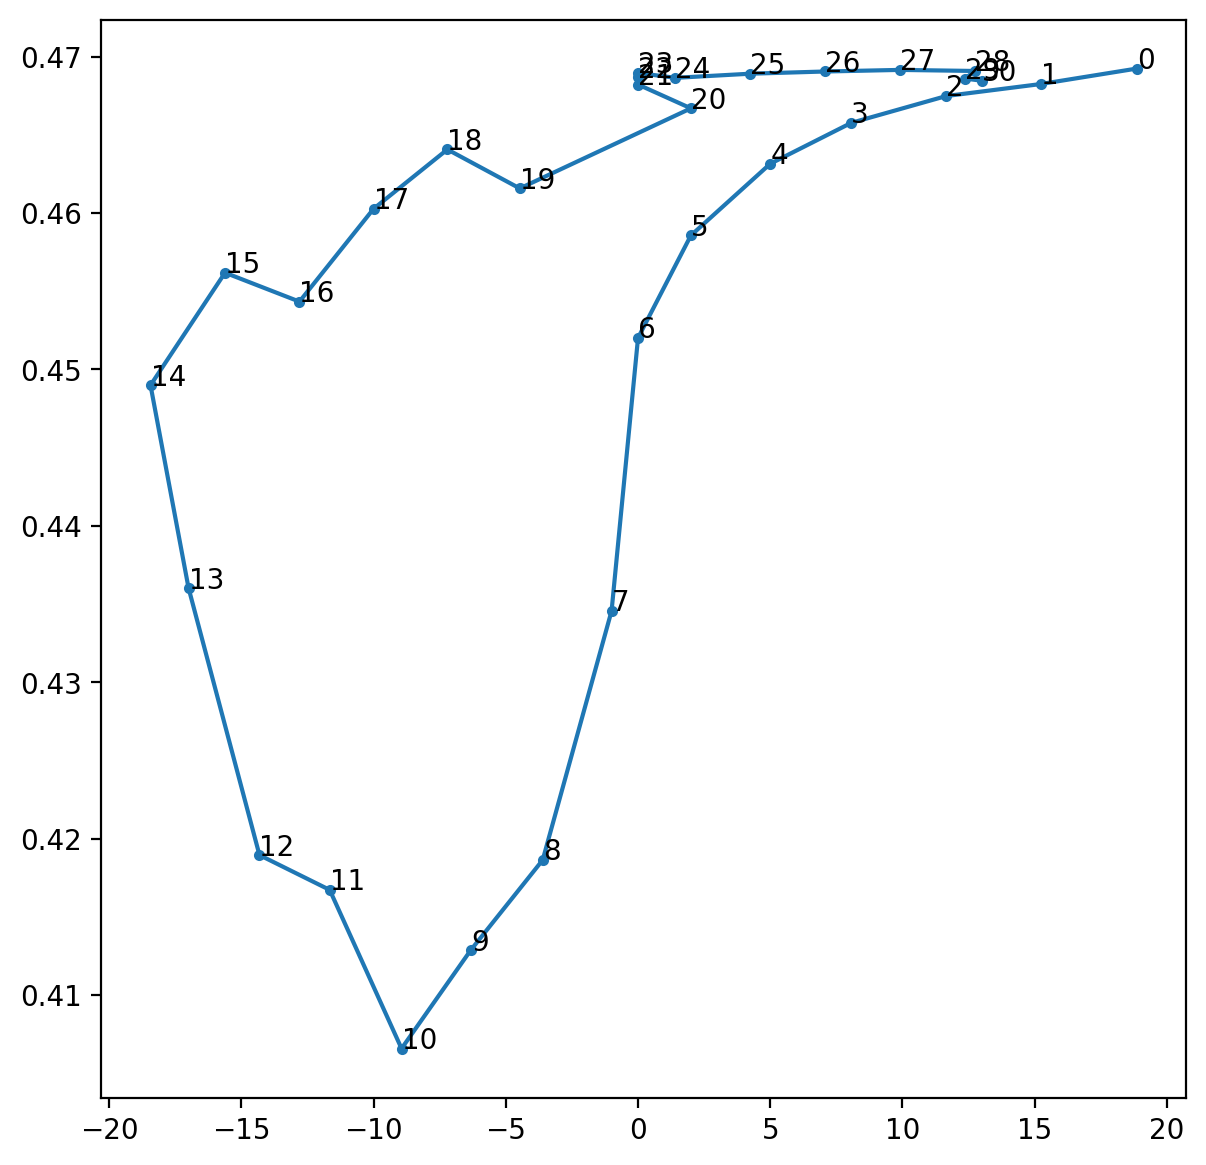

In [27]:
fig, ax = plt.subplots(figsize=(7,7))
n = np.arange(32)
ax.plot(closestApproach[closestApproach <= 20], d, marker='.')
for i, txt in enumerate(n):
    ax.annotate(txt, (closestApproach[closestApproach <= 20][i], d[i]))

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
n = np.arange(32)
ax.plot(closestApproach[closestApproach <= 20], d, marker='.')
for i, txt in enumerate(n):
    ax.annotate(txt, (closestApproach[closestApproach <= 20][i], d[i]))